In [1]:
import os
os.environ['KERAS_BACKEND'] = 'theano'
os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=gpu0,floatX=float32'
# os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=cpu,floatX=float32'

In [2]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display

import time
import numpy as np
import argparse
import cv2

import theano
import keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers.core import Dropout

from keras.optimizers import SGD, RMSprop
from keras.callbacks import Callback
from keras.callbacks import History
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.utils import np_utils
from sklearn.cross_validation import train_test_split
from sklearn import datasets

print 'Keras ', keras.__version__
print 'Theano', theano.__version__
print 'OpenCV', cv2.__version__
print 'Numpy ', np.__version__

Using gpu device 0: Tesla C2050 (CNMeM is disabled, cuDNN not available)
Using Theano backend.


Keras  1.2.1
Theano 0.8.2
OpenCV 2.4.10
Numpy  1.10.4


In [3]:
from keras.datasets import mnist
from my_keras_utilities import (load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 1, 28, 28) / 255.0
X_test = X_test.reshape(-1, 1, 28, 28) / 255.0

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

print X_train.shape, X_test.shape
print y_train.shape, y_test.shape

(60000, 1, 28, 28) (10000, 1, 28, 28)
(60000, 10) (10000, 10)


In [4]:
model_name = './keras_lenet_1'

class LeNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model
        model = Sequential()
        
        # first set of CONV => RELU => POOL
        model.add(Convolution2D(20, 5, 5, border_mode="same", 
                                input_shape=(depth, height, width)))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        # second set of CONV => RELU => POOL
        model.add(Convolution2D(50, 5, 5, border_mode="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        model.add(Dropout(0.5))
        
        # set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation("relu"))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model


[INFO] evaluating...
 9984/10000 [============================>.] - ETA: 0s[INFO] accuracy: 99.30%


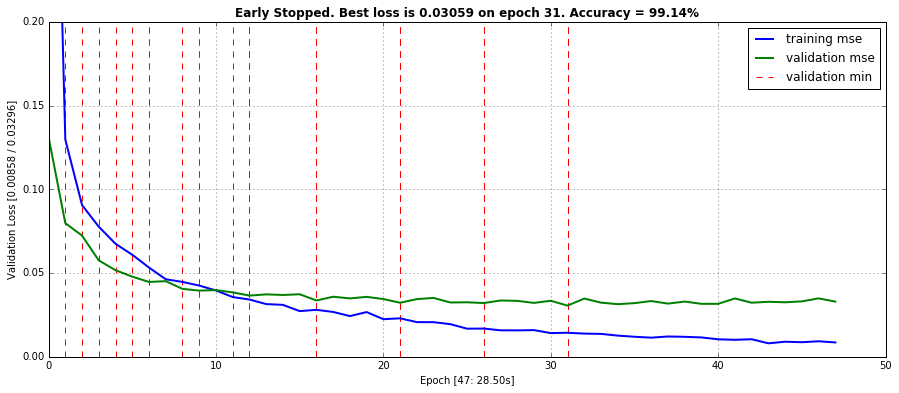

In [5]:
nepochs = 50
ploss = 0.2

if not os.path.isfile(model_name + '.model'):
    print("[INFO] creating model...")
    model = LeNet.build(width=28, height=28, depth=1, classes=10)
    
    # History, checkpoint, earlystop, plot losses:
    my_big_callback = TrainingPlotter(n=1, filepath=model_name, patience=15)
    
    # initialize the optimizer and model
    print("[INFO] compiling model...")
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])    
    
else:
    print("[INFO] loading model...")
    model, my_big_callback = load_model_and_history(model_name)

past_epochs = my_big_callback.get_nepochs()

fig = plot.figure(figsize=(15,6))
plot.ylim(0.0, ploss)
plot.xlim(0, nepochs)
plot.grid(True)

print("[INFO] training...")
try:
    histo2 = model.fit(X_train, y_train, batch_size=128, nb_epoch=nepochs - past_epochs, 
                       verbose=0, validation_split=0.33, callbacks=[my_big_callback])
except KeyboardInterrupt:
    pass

print("[INFO] evaluating...")
loss, accuracy = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
print("[INFO] accuracy: {:.2f}%".format(accuracy * 100))


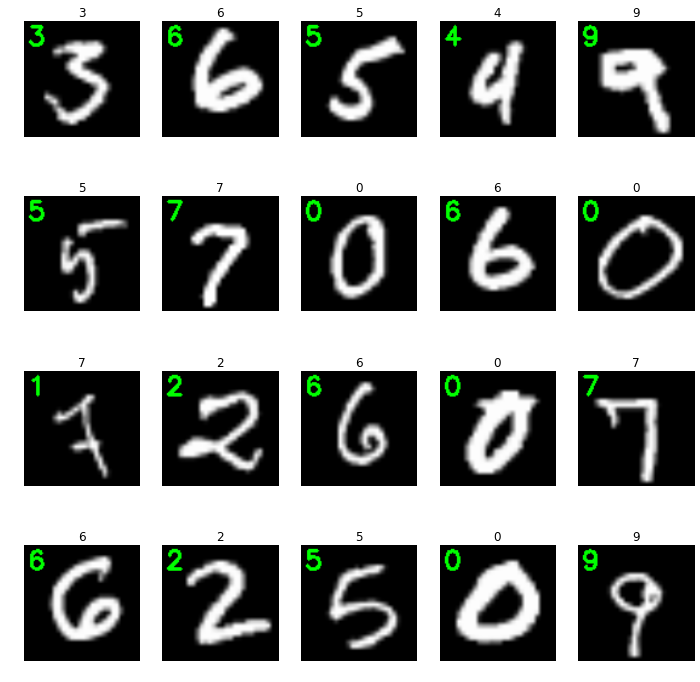

In [8]:
# randomly select a few testing digits
plot.figure(figsize=(12, 12))

for k, i in enumerate(np.random.choice(np.arange(0, len(y_test)), size=(20,))):
    plot.subplot(4, 5, k + 1)
    # classify the digit
    probs = model.predict(X_test[np.newaxis, i])
    prediction = probs.argmax(axis=1)

    # resize the image from a 28 x 28 image to a 96 x 96 image so we
    # can better see it
    image = (X_test[i][0] * 255).astype("uint8")
    image = cv2.merge([image] * 3)
    image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
    cv2.putText(image, str(prediction[0]), (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, 
                (0, 255, 0), 2)

    # show the image and prediction
    vreal = np.argmax(y_test[i])
    # print("[INFO] Predicted: {}, Actual: {}".format(prediction[0], vreal))
    plot.imshow(image)
    plot.axis('off')
    plot.title('{}'.format(vreal))
